In [1]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers, callbacks, seed_everything
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd 
import transformers
import swifter

from transformers import AutoTokenizer, AutoModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import os 
import random

import utils, models, datasets

## Config & constants

In [2]:
data_dir = '../data'
models_dir = '../models'


In [3]:
train_data_path = os.path.join(data_dir, 'TrainV1.csv')
test_data_path = os.path.join(data_dir, 'Test.csv')
ss_path = os.path.join(data_dir, 'SampleSubmission.csv')


In [4]:
#! python utils.py --data_path ../data/Train.csv

## EDA

In [5]:
%%time
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
ss = pd.read_csv(ss_path)

CPU times: user 4.64 s, sys: 334 ms, total: 4.98 s
Wall time: 5.03 s


In [6]:
test.head()

,SEQUENCE_ID,SEQUENCE,CREATURE
0,000LRRAI,MKLPVKRYAVAAIVALGVSMAPGELRTSPEAQIKIATREECRATPY...,creature7
1,000O8L4W,MKISVFGSGYVGLVQAAVLAEVGHDVVCMDIDKVKVEQLSQGQVHI...,creature6
2,000UKB5J,MTMKVGFIGLGIMGKPMSKNLLKAGYSLVVADRNPEAIADVIAAGA...,creature7
3,00111SLH,MTVSLSRLERQLGYTFKDQELMILALTHRSFAGRNNERLEFLGDAI...,creature6
4,001ELB0A,MSKIRVLSVDDSALMRQIMTEIINSHSDMEMVATAPDPLVARDLIK...,creature7


In [7]:
ss.head()

,SEQUENCE_ID,LABEL
0,000LRRAI,NaN
1,000O8L4W,NaN
2,000UKB5J,NaN
3,00111SLH,NaN
4,001ELB0A,NaN


In [8]:
train.head()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL,TARGET,LENGTH
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11,3,296
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13,5,306
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16,8,348
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12,4,461
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13,5,184


In [9]:
train.SEQUENCE.nunique() == len(train)

False

In [10]:
train.CREATURE.nunique(), train.LABEL.nunique()

(8, 20)

In [11]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SEQUENCE_ID,858777,858777,GLXL3B29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEQUENCE,858777,816700,FFRENLAFPEGEAREFPSEQTRAIGPTRGEPQVWGRSSNSLSEAGG...,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREATURE,858777,8,creature8,140738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LABEL,858777,20,class19,256273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TARGET,858777,NaN,NaN,NaN,10.193,5.13289,0,6,11,14,19
LENGTH,858777,NaN,NaN,NaN,407.55,211.881,16,263,381,481,1234


In [12]:
n_duplicates = 858777 - 816700
n_duplicates

42077

In [13]:
class_distrib = dict(train.LABEL.value_counts())
list(class_distrib.values())

[256273,
 62087,
 52784,
 46636,
 45052,
 37866,
 36916,
 36666,
 35987,
 35438,
 32719,
 32301,
 29631,
 28414,
 19286,
 17792,
 14923,
 13967,
 12930,
 11109]

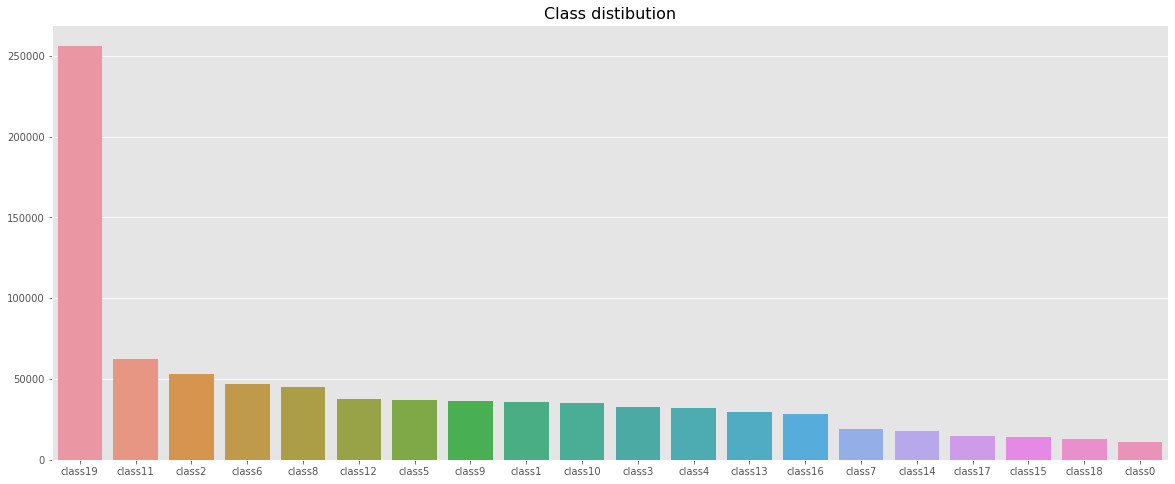

In [14]:
plt.figure(figsize=(20, 8))
sns.barplot(x=list(class_distrib.keys()), y=list(class_distrib.values()))
plt.title('Class distibution', size=16)
plt.show()

In [15]:
less_rep_cls, most_rep_cls = min(class_distrib.values()), max(class_distrib.values())

print(f"> Less represented class has : {less_rep_cls} items ({(less_rep_cls / len(train)*100):.2f}% of training data)")
print(f"> Most represented class has : {most_rep_cls} items ({(most_rep_cls / len(train)*100):.2f}% of training data)")

> Less represented class has : 11109 items (1.29% of training data)
> Most represented class has : 256273 items (29.84% of training data)


In [16]:
def get_used_letters(df:pd.DataFrame):
    all_seqs_list = df.SEQUENCE.values.tolist()
    v = ""
    v += "".join(seq for seq in all_seqs_list)

    return sorted(list(set(v)))



# Datasets & Dataloaders

In [17]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 600
ds = datasets.EnzymeDataset(df=train, task='train')
dl = DataLoader(dataset=ds, 
                batch_size=BATCH_SIZE,
                num_workers=os.cpu_count())

In [18]:
for data in dl:
    xs, ys = data['sequence'], data['target']
    print(xs.shape)
    print(ys.shape)
    break

torch.Size([32, 1, 512])
torch.Size([32])


## Modeling 

## Evaluation & Results

In [21]:
## Inference